In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
#import sweetviz as sv
from scipy import stats
import warnings
#from statsmodels.tsa.arima.model import ARIMA

In [16]:
df = pd.read_csv('../data/CPN50_cement_composition_strength.csv')

In [17]:
df_cleaned = df.drop(columns=['Unnamed: 0', 'date', 'ric', 'nat', 'pl', 'em', 'ml', 'rie', 'g75µ', 'r91_iram1622', 'r2_iram1622', 'r3_iram1622', 'r7_iram1622', 'r28_iram1622'])

In [18]:
df_cleaned.describe()

,g45µ,sba,r1_iram1622,pf,so3,mgo,sio2,fe2o3,caot,al2o3,na2o,k2o
count,1044.000000,1042.000000,406.000000,1042.000000,1046.000000,1045.000000,1046.000000,1046.000000,1046.000000,1046.000000,1043.000000,1046.000000
mean,2.210038,418.784069,18.278079,2.675355,2.879082,0.759062,20.974713,4.345736,62.098948,4.167782,0.085829,0.992103
std,0.526979,19.932075,2.278062,0.878959,0.137584,0.186473,1.161756,0.384277,0.977661,0.486329,0.051445,0.393442
min,0.060000,330.000000,12.100000,1.360000,0.660000,0.000000,17.730000,0.800000,59.690000,2.840000,0.000000,0.030000
25%,1.880000,407.000000,16.900000,1.900000,2.840000,0.660000,19.830000,4.080000,61.250000,3.820000,0.040000,0.880000
50%,2.150000,418.000000,18.250000,2.310000,2.880000,0.780000,21.065000,4.310000,62.115000,4.040000,0.100000,0.970000
75%,2.440000,430.000000,19.800000,3.570000,2.920000,0.840000,21.997500,4.650000,62.917500,4.650000,0.130000,1.090000
max,6.000000,502.000000,32.500000,6.020000,3.270000,4.320000,23.040000,5.290000,66.140000,5.430000,0.960000,9.100000


In [19]:
df_cleaned.dropna(axis=0, how='all', inplace=True)

In [20]:
df_cleaned.dropna(subset=['r1_iram1622'], inplace=True)

In [21]:
df_cleaned

,g45µ,sba,r1_iram1622,pf,so3,mgo,sio2,fe2o3,caot,al2o3,na2o,k2o
1,4.45,399.0,19.1,1.58,2.88,0.71,22.62,4.08,61.09,4.58,0.13,1.01
4,3.46,392.0,17.5,2.01,2.85,0.69,22.67,4.16,61.07,4.64,0.13,1.04
10,2.47,405.0,17.1,2.15,2.88,0.72,21.70,4.66,61.90,4.79,0.11,1.20
15,2.21,415.0,17.0,1.95,2.90,0.74,20.71,4.19,60.80,4.77,0.13,0.90
21,3.10,417.0,18.4,2.25,2.89,0.68,22.59,4.07,60.66,4.71,0.12,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...
1055,2.53,398.0,18.1,4.04,2.71,0.67,19.85,4.18,62.93,3.76,0.04,0.95
1057,2.49,416.0,16.1,4.11,2.95,0.69,19.98,4.08,62.98,3.85,0.04,0.98
1059,2.12,416.0,17.1,3.82,2.84,0.69,20.02,4.11,63.12,3.81,0.03,0.95
1061,2.03,405.0,14.7,3.55,2.81,0.66,20.06,4.40,63.04,3.80,0.03,0.90


In [22]:
list_target_cols = [x for x in df_cleaned.columns if x.startswith("r")]
list_target_cols

['r1_iram1622']

In [23]:
df_target = df_cleaned.copy()
df_target = df_cleaned[list_target_cols]
df_target.head()

,r1_iram1622
1,19.1
4,17.5
10,17.1
15,17.0
21,18.4


In [24]:
# Select only numerical columns for KNN imputation
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(list_target_cols)

df_numeric = df_cleaned.copy()
df_numeric = df_numeric[numeric_columns]

df_numeric.head()

,g45µ,sba,pf,so3,mgo,sio2,fe2o3,caot,al2o3,na2o,k2o
1,4.45,399.0,1.58,2.88,0.71,22.62,4.08,61.09,4.58,0.13,1.01
4,3.46,392.0,2.01,2.85,0.69,22.67,4.16,61.07,4.64,0.13,1.04
10,2.47,405.0,2.15,2.88,0.72,21.70,4.66,61.90,4.79,0.11,1.20
15,2.21,415.0,1.95,2.90,0.74,20.71,4.19,60.80,4.77,0.13,0.90
21,3.10,417.0,2.25,2.89,0.68,22.59,4.07,60.66,4.71,0.12,1.12


In [25]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

df_scaled = pd.DataFrame(scaled_data, columns=df_numeric.columns)

df_scaled.head()

,g45µ,sba,pf,so3,mgo,sio2,fe2o3,caot,al2o3,na2o,k2o
0,4.328897,-0.782058,-1.554600,0.000151,-0.120479,1.914775,-0.630581,-1.499334,1.393533,1.569875,0.052266
1,2.413300,-1.106185,-1.075254,-0.180488,-0.237016,1.960176,-0.414243,-1.521387,1.533049,1.569875,0.101958
2,0.497703,-0.504236,-0.919187,0.000151,-0.062211,1.079401,0.937874,-0.606200,1.881840,1.074650,0.366983
3,-0.005383,-0.041198,-1.142139,0.120577,0.054325,0.180465,-0.333116,-1.819098,1.835335,1.569875,-0.129939
4,1.716719,0.051410,-0.807712,0.060364,-0.295284,1.887535,-0.657624,-1.973467,1.695818,1.322262,0.234471


In [26]:
df_scaled = df_scaled.reset_index(drop=True)
df_target = df_target.reset_index(drop=True)
df_preprocessed = pd.concat([df_scaled, df_target], axis=1)

df_preprocessed.head()

,g45µ,sba,pf,so3,mgo,sio2,fe2o3,caot,al2o3,na2o,k2o,r1_iram1622
0,4.328897,-0.782058,-1.554600,0.000151,-0.120479,1.914775,-0.630581,-1.499334,1.393533,1.569875,0.052266,19.1
1,2.413300,-1.106185,-1.075254,-0.180488,-0.237016,1.960176,-0.414243,-1.521387,1.533049,1.569875,0.101958,17.5
2,0.497703,-0.504236,-0.919187,0.000151,-0.062211,1.079401,0.937874,-0.606200,1.881840,1.074650,0.366983,17.1
3,-0.005383,-0.041198,-1.142139,0.120577,0.054325,0.180465,-0.333116,-1.819098,1.835335,1.569875,-0.129939,17.0
4,1.716719,0.051410,-0.807712,0.060364,-0.295284,1.887535,-0.657624,-1.973467,1.695818,1.322262,0.234471,18.4


In [27]:
df_scaled

,g45µ,sba,pf,so3,mgo,sio2,fe2o3,caot,al2o3,na2o,k2o
0,4.328897,-0.782058,-1.554600,0.000151,-0.120479,1.914775,-0.630581,-1.499334,1.393533,1.569875,0.052266
1,2.413300,-1.106185,-1.075254,-0.180488,-0.237016,1.960176,-0.414243,-1.521387,1.533049,1.569875,0.101958
2,0.497703,-0.504236,-0.919187,0.000151,-0.062211,1.079401,0.937874,-0.606200,1.881840,1.074650,0.366983
3,-0.005383,-0.041198,-1.142139,0.120577,0.054325,0.180465,-0.333116,-1.819098,1.835335,1.569875,-0.129939
4,1.716719,0.051410,-0.807712,0.060364,-0.295284,1.887535,-0.657624,-1.973467,1.695818,1.322262,0.234471
...,...,...,...,...,...,...,...,...,...,...,...
401,0.613800,-0.828362,1.187708,-1.023468,-0.353553,-0.600428,-0.360158,0.529513,-0.513192,-0.658636,-0.047118
402,0.536402,0.005106,1.265741,0.421641,-0.237016,-0.482386,-0.630581,0.584645,-0.303917,-0.658636,0.002574
403,-0.179528,0.005106,0.942461,-0.240701,-0.237016,-0.446066,-0.549454,0.739014,-0.396928,-0.906249,-0.047118
404,-0.353673,-0.504236,0.641476,-0.421339,-0.411821,-0.409745,0.234774,0.650803,-0.420181,-0.906249,-0.129939


In [28]:
df_target

,r1_iram1622
0,19.1
1,17.5
2,17.1
3,17.0
4,18.4
...,...
401,18.1
402,16.1
403,17.1
404,14.7


In [29]:
df_preprocessed

,g45µ,sba,pf,so3,mgo,sio2,fe2o3,caot,al2o3,na2o,k2o,r1_iram1622
0,4.328897,-0.782058,-1.554600,0.000151,-0.120479,1.914775,-0.630581,-1.499334,1.393533,1.569875,0.052266,19.1
1,2.413300,-1.106185,-1.075254,-0.180488,-0.237016,1.960176,-0.414243,-1.521387,1.533049,1.569875,0.101958,17.5
2,0.497703,-0.504236,-0.919187,0.000151,-0.062211,1.079401,0.937874,-0.606200,1.881840,1.074650,0.366983,17.1
3,-0.005383,-0.041198,-1.142139,0.120577,0.054325,0.180465,-0.333116,-1.819098,1.835335,1.569875,-0.129939,17.0
4,1.716719,0.051410,-0.807712,0.060364,-0.295284,1.887535,-0.657624,-1.973467,1.695818,1.322262,0.234471,18.4
...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.613800,-0.828362,1.187708,-1.023468,-0.353553,-0.600428,-0.360158,0.529513,-0.513192,-0.658636,-0.047118,18.1
402,0.536402,0.005106,1.265741,0.421641,-0.237016,-0.482386,-0.630581,0.584645,-0.303917,-0.658636,0.002574,16.1
403,-0.179528,0.005106,0.942461,-0.240701,-0.237016,-0.446066,-0.549454,0.739014,-0.396928,-0.906249,-0.047118,17.1
404,-0.353673,-0.504236,0.641476,-0.421339,-0.411821,-0.409745,0.234774,0.650803,-0.420181,-0.906249,-0.129939,14.7


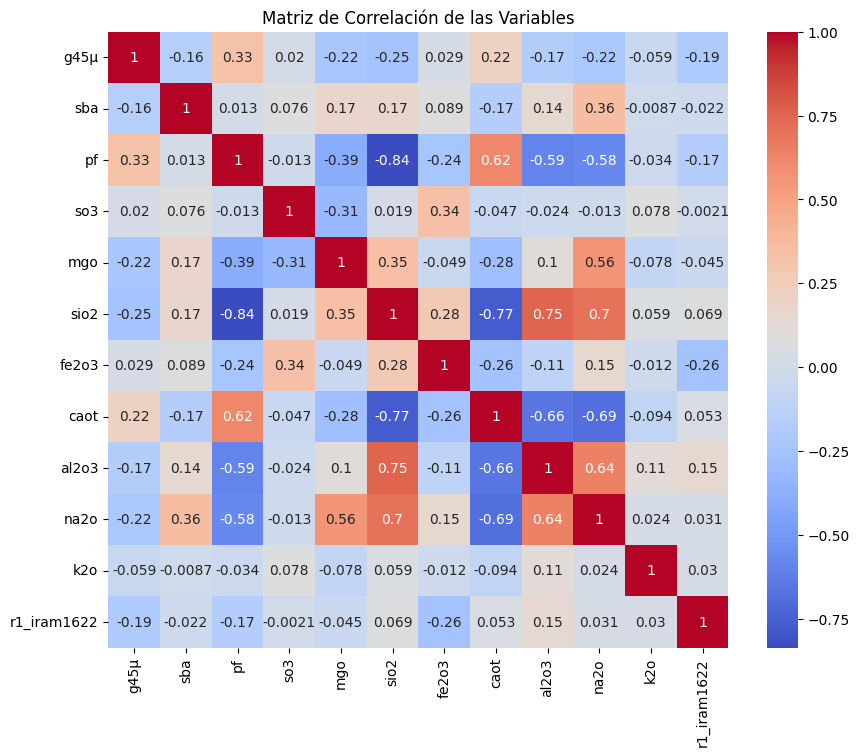

In [32]:
correlation_matrix = df_preprocessed.corr()
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación de las Variables")
plt.show()

In [34]:
train_size = int(len(df_preprocessed) * 0.8)

# Split the dataset into training and test without mixing the temporal order.
training_data = df_preprocessed.iloc[:train_size]
testing_data = df_preprocessed.iloc[train_size:]

In [35]:
# Remove Features based on completion thresholds

# Create feature threshold benchmark
feature_missing_threshold = 0.8

# Check for missing values in the training dataset
missing_values = training_data.isna().sum() / training_data.count()

print("Features with missing values more than threshold: ", missing_values[missing_values > feature_missing_threshold])

# Create a list of features without missing values
features_without_missing_values = missing_values[missing_values < feature_missing_threshold].index.tolist()

# Print the list of features without missing values
print("Features without missing values converted to list for INDEX", features_without_missing_values)

# Take subset of data with updated feature list
training_data = training_data[features_without_missing_values]

Features with missing values more than threshold:  Series([], dtype: float64)
Features without missing values converted to list for INDEX ['g45µ', 'sba', 'pf', 'so3', 'mgo', 'sio2', 'fe2o3', 'caot', 'al2o3', 'na2o', 'k2o', 'r1_iram1622']


In [36]:
# Impute missing data for Features

# Calculate the median from the training data
median_values = training_data.median()

# Fill missing values in the training data with the median
training_data = training_data.fillna(median_values)
print("New training data:", training_data.shape)

# Fill missing values in the testing data with the same median values
testing_data = testing_data.fillna(median_values)

New training data: (324, 12)


In [37]:
# Outlier Removal

# Calculate z-scores for the target column
z_scores = stats.zscore(training_data['r1_iram1622'])

# Define a threshold for outlier detection (Z-score > 3 or < -3)
threshold = 2

# Filter out rows where Z-score exceeds the threshold
training_data_no_outliers = training_data[(z_scores < threshold) & (z_scores > -threshold)]

print("Outliers:\n\n", training_data[(z_scores >= threshold) | (z_scores <= -threshold)])

Outliers:

          g45µ       sba        pf       so3       mgo      sio2     fe2o3  \
7    0.594450  0.514448 -0.986073  0.180790 -0.644894  1.742252  0.180689   
14   0.091364 -0.457932 -1.443124 -0.060062 -0.353553  0.943199 -0.387200   
57  -0.914808  0.051410 -0.997221  0.060364  0.637008  1.233764 -1.550021   
64  -1.108302  0.051410 -1.287058 -0.120275  0.054325  1.960176 -1.279597   
96  -0.218227  0.560752 -1.331648 -0.060062  0.811813  1.015840  1.208298   
104 -1.108302 -0.180109 -1.220173  0.481854  1.336227  1.606050  1.857314   
106 -0.527818 -0.365324 -1.376239  0.060364  1.569300  1.369966  2.641542   
107 -0.701964 -0.226413 -1.353944 -0.421339  1.569300  1.451687  2.641542   
108 -0.740663  0.190321 -1.353944  0.180790  1.685837  1.360886  2.208864   
109 -0.566517  0.097714 -1.376239 -0.180488  1.336227  1.506168  2.614499   
111 -0.469770 -0.226413 -1.666076  0.180790  0.753544  1.024920  1.343510   
112 -0.972856  0.282929 -1.588043 -0.361126  1.103154  1.360886 

In [38]:
# Remove Correlated Features

# Remove highly correlated features
# Set threshold
corr_threshold = 0.9

# Calculate the correlation matrix
corr_matrix = training_data_no_outliers.drop(['r1_iram1622'], axis=1).corr().abs()

# Create a mask to identify highly correlated features
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]

# Drop highly correlated features
training_data_no_outliers.drop(highly_correlated, axis=1, inplace=True)
features_without_missing_values = [feature for feature in features_without_missing_values if feature not in highly_correlated]

print("Features Dropped: ", highly_correlated)

Features Dropped:  []


C:\Users\JUAN SEBASTIAN\AppData\Local\Temp\ipykernel_11836\1694535104.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_no_outliers.drop(highly_correlated, axis=1, inplace=True)


In [39]:
# Split Data

# Split training data into train and test

# Define the feature columns (excluding 'r1_iram1622' which is the target)
feature_columns = features_without_missing_values.copy()

# Split the data into features (X) and the target (y)
y = training_data_no_outliers['r1_iram1622']

# Remove 'r1_iram1622'  from the list of feature columns
feature_columns.remove('r1_iram1622')

X = training_data_no_outliers[feature_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=112)


In [41]:
# Split the data into training and testing sets


training_data_sorted = training_data_no_outliers
print(training_data_sorted)

# Extract the last 20 samples for testing
testing_data = training_data_sorted.iloc[-20:]
X_test = testing_data.drop(['r1_iram1622'], axis=1)
y_test = testing_data['r1_iram1622']

# Extract the remaining data for training
training_data = training_data_sorted.iloc[:-20]
X_train = training_data.drop(['r1_iram1622'], axis=1)
y_train = training_data['r1_iram1622']

         g45µ       sba        pf       so3       mgo      sio2     fe2o3  \
0    4.328897 -0.782058 -1.554600  0.000151 -0.120479  1.914775 -0.630581   
1    2.413300 -1.106185 -1.075254 -0.180488 -0.237016  1.960176 -0.414243   
2    0.497703 -0.504236 -0.919187  0.000151 -0.062211  1.079401  0.937874   
3   -0.005383 -0.041198 -1.142139  0.120577  0.054325  0.180465 -0.333116   
4    1.716719  0.051410 -0.807712  0.060364 -0.295284  1.887535 -0.657624   
..        ...       ...       ...       ...       ...       ...       ...   
319 -0.102130 -2.448995  0.674918 -0.120275 -0.411821 -0.754791 -0.522412   
320 -0.566517  0.051410  0.708361  0.361428 -0.120479 -0.682150 -0.306073   
321 -0.334324 -1.106185 -0.506727  0.602280  0.112594 -0.373424  0.126604   
322 -1.147001  1.023790  0.039506 -0.601978  0.170862 -0.473306 -0.224946   
323 -0.682614  1.672043  0.541147 -0.662191  0.170862 -0.446066 -0.224946   

         caot     al2o3      na2o       k2o  r1_iram1622  
0   -1.499334  1

In [42]:
# Prune Tail of Features for Reducing Overfitting

# Remove features of very low importance
# Train RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

threshold_feature_imp = 0.0001

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
low_importance_features = feature_importance[feature_importance < threshold_feature_imp].index.tolist()

print("Total number of features: ", len(feature_importance))
print("Count of low importance features removed: ", len(low_importance_features))

# Remove features with low importance
X_train.drop(low_importance_features, axis=1, inplace=True)
X_test.drop(low_importance_features, axis=1, inplace=True)

Total number of features:  11
Count of low importance features removed:  0


In [43]:
# Filter warnings related to Git or other irrelevant warnings
warnings.filterwarnings("ignore", message="Failed to import Git", category=UserWarning)

# Initialize models and their hyperparameters
models = {
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {
            "n_estimators": [100, 200, 300, 400],
            "max_depth": [5, 10, 15],
        },
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=42),
        {
            "n_estimators": [50, 100, 150, 200],
            "learning_rate": [0.1, 0.01],
        },
    ),
    "LinearRegression": (
        LinearRegression(),
        {},
    ),
    "SVM": (
        SVR(),
        {
            "C": [1, 10],
            "kernel": ["linear", "rbf"],
        },
    ),
    "Ridge": (
        Ridge(random_state=42),
        {"alpha": [0.1, 1.0, 10.0]},
    ),
    "Lasso": (
        Lasso(random_state=42),
        {"alpha": [0.1, 1.0, 10.0]},
    ),
}

# Initialize variables for the best model
best_model_name = None
best_model = None
best_mae = float("inf")

# Perform hyperparameter search (Grid Search) for each model
print("Starting Grid Search...\n")

for model_name, (model, param_grid) in models.items():
    print(f"Training model: {model_name}...")
    
    # Perform Grid Search to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", cv=5)
    grid_search.fit(X_train, y_train)
    
    # Get the best model and make predictions
    top_model = grid_search.best_estimator_
    y_pred = top_model.predict(X_test)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Model: {model_name} | Test MAE: {mae:.4f} | Best Parameters: {grid_search.best_params_}")

    # Update the best model if the MAE is lower
    if mae < best_mae:
        best_mae = mae
        best_model_name = model_name
        best_model = top_model

print("\nGrid Search completed.")
print(f"Best model: {best_model_name}")
print(f"Best MAE: {best_mae:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate the best model on training and test data
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)

test_mae = mean_absolute_error(y_test, test_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)

print("\nEvaluation of the best model:")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train MAE: {train_mae:.4f}")


Starting Grid Search...

Training model: RandomForest...
Model: RandomForest | Test MAE: 1.1873 | Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Training model: GradientBoosting...
Model: GradientBoosting | Test MAE: 1.1653 | Best Parameters: {'learning_rate': 0.01, 'n_estimators': 50}
Training model: LinearRegression...
Model: LinearRegression | Test MAE: 1.0468 | Best Parameters: {}
Training model: SVM...
Model: SVM | Test MAE: 1.0679 | Best Parameters: {'C': 1, 'kernel': 'linear'}
Training model: Ridge...
Model: Ridge | Test MAE: 1.0278 | Best Parameters: {'alpha': 10.0}
Training model: Lasso...
Model: Lasso | Test MAE: 1.0409 | Best Parameters: {'alpha': 0.1}

Grid Search completed.
Best model: Ridge
Best MAE: 1.0278
Best parameters: {'alpha': 0.1}

Evaluation of the best model:
Test MAE: 1.0278
Train MAE: 1.3910


In [ ]:
# Test the Moving Average Method as a baseline MAE

# Define the moving average function
def moving_average_forecast(data, window_size):
    """
    Generate a moving average forecast for the given data and window size.

    Args:
        data (list or array-like): The data to calculate the moving average on.
        window_size (int): The number of data points to include in the moving average window.

    Returns:
        list: The moving average forecast.
    """
    forecast = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        forecast.append(sum(window) / window_size)
    return forecast

# Define the window size for the moving average
window_size = 8  # You can adjust and test with multiple values

# Calculate moving average forecast on the training set
train_forecast = moving_average_forecast(y_train, window_size)

# Calculate moving average forecast on the test set
test_forecast = moving_average_forecast(y_test, window_size)

# Compute MAE for the moving average forecast on the training set
train_mae = mean_absolute_error(y_train[window_size - 1:], train_forecast)

# Compute MAE for the moving average forecast on the test set
test_mae = mean_absolute_error(y_test[window_size - 1:], test_forecast)

# Print the Moving Average Train and Test MAE
print("Moving Average Train MAE:", train_mae)
print("Moving Average Test MAE:", test_mae)

In [44]:
# Test the Moving Average Method as a baseline MAE

# Define the moving average function
def moving_average_forecast(data, window_size):
    """
    Generate a moving average forecast for the given data and window size.

    Args:
        data (list or array-like): The data to calculate the moving average on.
        window_size (int): The number of data points to include in the moving average window.

    Returns:
        list: The moving average forecast.
    """
    forecast = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        forecast.append(sum(window) / window_size)
    return forecast

# Define the window size for the moving average
window_size = 8  # You can adjust and test with multiple values

# Calculate moving average forecast on the training set
train_forecast = moving_average_forecast(y_train, window_size)

# Calculate moving average forecast on the test set
test_forecast = moving_average_forecast(y_test, window_size)

# Compute MAE for the moving average forecast on the training set
train_mae = mean_absolute_error(y_train[window_size - 1:], train_forecast)

# Compute MAE for the moving average forecast on the test set
test_mae = mean_absolute_error(y_test[window_size - 1:], test_forecast)

# Print the Moving Average Train and Test MAE
print("Moving Average Train MAE:", train_mae)
print("Moving Average Test MAE:", test_mae)

Moving Average Train MAE: 1.283494718309859
Moving Average Test MAE: 1.2644230769230778


In [45]:
# Linear Regression with Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Initialize a Linear Regression model
model = LinearRegression()

# Initialize RFE with the Linear Regression model
# Set the number of features to select (n_features_to_select) based on your needs
rfe = RFE(model, n_features_to_select=20)  # Adjust the number of features as required

# Fit RFE to your training data (X_train) and target variable (y_train)
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Train a Linear Regression model using the selected features
model.fit(X_train[selected_features], y_train)

# Make predictions on the test set using the selected features
y_pred = model.predict(X_test[selected_features])
y_train_pred = model.predict(X_train[selected_features])

# Calculate the performance metric (e.g., mean_absolute_error)
test_mae = mean_absolute_error(y_test, y_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Print training and testing MAE
print("Training MAE with selected features:", train_mae)
print("Test MAE with selected features:", test_mae)

Selected Features: Index(['g45µ', 'sba', 'pf', 'so3', 'mgo', 'sio2', 'fe2o3', 'caot', 'al2o3',
       'na2o', 'k2o'],
      dtype='object')
Training MAE with selected features: 1.3843875771365475
Test MAE with selected features: 1.0467965587717238


d:\Bootcamp IA\Proyecto_Final\proyecto_final_talento_tech\.venv\lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=20 > n_features=11. There will be no feature selection and all features will be kept.
  warnings.warn(


In [46]:
# Create Model with RFE Based Features Selection
selected_features = selected_features.copy()

# Keep only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [47]:
# Initialize models and their hyperparameters
models = {
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {
            "n_estimators": [100, 200, 300, 400],
            "max_depth": [5, 10, 15],
        },
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=42),
        {
            "n_estimators": [50, 100, 150, 200],
            "learning_rate": [0.1, 0.01],
        },
    ),
    "LinearRegression": (
        LinearRegression(),
        {},
    ),
    "SVM": (
        SVR(),
        {
            "C": [1, 10],
            "kernel": ["linear", "rbf"],
        },
    ),
    "Ridge": (
        Ridge(random_state=42),
        {"alpha": [0.1, 1.0, 10.0]},
    ),
    "Lasso": (
        Lasso(random_state=42),
        {"alpha": [0.1, 1.0, 10.0]},
    ),
}

# Initialize variables for the best model
best_model_name = None
best_model = None
best_mae = float("inf")

# Perform hyperparameter tuning for each model
print("Beginning Grid Search...\n")

for model_name, (model, param_grid) in models.items():
    print(f"Training model: {model_name}...")
    
    # Perform Grid Search to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", cv=5)
    grid_search.fit(X_train, y_train)
    
    # Get the best model and make predictions on the test data
    top_model = grid_search.best_estimator_
    y_pred = top_model.predict(X_test)
    
    # Calculate Mean Absolute Error (MAE) for the model
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Model Name: {model_name} | Test MAE: {mae:.4f} | Best Parameters: {grid_search.best_params_}")

    # Update the best model if it has the lowest MAE
    if mae < best_mae:
        best_mae = mae
        best_model_name = model_name
        best_model = top_model

print("\nGrid Search completed.")
print(f"Best Model Name: {best_model_name}")
print(f"Best Model Test MAE: {best_mae:.4f}")
print(f"Best Model Parameters: {grid_search.best_params_}")

# Evaluate the best model on the training and test data
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)

test_mae = mean_absolute_error(y_test, test_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)

# Print evaluation results
print("\nEvaluation of the Best Model:")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train MAE: {train_mae:.4f}")


Beginning Grid Search...

Training model: RandomForest...
Model Name: RandomForest | Test MAE: 1.1873 | Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Training model: GradientBoosting...
Model Name: GradientBoosting | Test MAE: 1.1653 | Best Parameters: {'learning_rate': 0.01, 'n_estimators': 50}
Training model: LinearRegression...
Model Name: LinearRegression | Test MAE: 1.0468 | Best Parameters: {}
Training model: SVM...
Model Name: SVM | Test MAE: 1.0679 | Best Parameters: {'C': 1, 'kernel': 'linear'}
Training model: Ridge...
Model Name: Ridge | Test MAE: 1.0278 | Best Parameters: {'alpha': 10.0}
Training model: Lasso...
Model Name: Lasso | Test MAE: 1.0409 | Best Parameters: {'alpha': 0.1}

Grid Search completed.
Best Model Name: Ridge
Best Model Test MAE: 1.0278
Best Model Parameters: {'alpha': 0.1}

Evaluation of the Best Model:
Test MAE: 1.0278
Train MAE: 1.3910


In [48]:
# Blend models to reduce overfitting in Grid Search

# Initialize models with their hyperparameters for Grid Search
models = {
    "RandomForest": (
        RandomForestRegressor(random_state=42),
        {"n_estimators": [100, 200, 300, 400], "max_depth": [5, 10, 15]}
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=42),
        {"n_estimators": [50, 100, 150, 200], "learning_rate": [0.1, 0.01]}
    ),
    "LinearRegression": (LinearRegression(), {}),
    "SVM": (
        SVR(),
        {"C": [1, 10], "kernel": ["linear", "rbf"]}
    ),
    "Ridge": (
        Ridge(random_state=42),
        {"alpha": [0.1, 1.0, 10.0]}
    ),
    "Lasso": (
        Lasso(random_state=42),
        {"alpha": [0.1, 1.0, 10.0]}
    )
}

# Initialize arrays to store predictions for the training and test sets
train_predictions = np.zeros(X_train.shape[0])
test_predictions = np.zeros(X_test.shape[0])

# Perform Grid Search for each model and blend their predictions
for model_name, (model, param_grid) in models.items():
    print(f"Training model: {model_name}...")
    grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", cv=5)
    
    # Fit the model using Grid Search
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    top_model = grid_search.best_estimator_
    
    # Make predictions on the train and test sets
    y_pred_train = top_model.predict(X_train)
    y_pred_test = top_model.predict(X_test)
    
    # Accumulate predictions for blending
    train_predictions += y_pred_train
    test_predictions += y_pred_test
    
    # Calculate MAE for the current model
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print(f"{model_name} - Train MAE: {mae_train:.4f}, Test MAE: {mae_test:.4f}")

# Average predictions across all models
train_predictions /= len(models)
test_predictions /= len(models)

# Calculate MAE for the blended model
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

# Print results
print("\nBlended Model Results:")
print(f"Training MAE with Blended Model: {train_mae:.4f}")
print(f"Test MAE with Blended Model: {test_mae:.4f}")

Training model: RandomForest...
RandomForest - Train MAE: 0.9794, Test MAE: 1.1873
Training model: GradientBoosting...
GradientBoosting - Train MAE: 1.4707, Test MAE: 1.1653
Training model: LinearRegression...
LinearRegression - Train MAE: 1.3844, Test MAE: 1.0468
Training model: SVM...
SVM - Train MAE: 1.3768, Test MAE: 1.0679
Training model: Ridge...
Ridge - Train MAE: 1.3910, Test MAE: 1.0278
Training model: Lasso...
Lasso - Train MAE: 1.4439, Test MAE: 1.0409

Blended Model Results:
Training MAE with Blended Model: 1.3213
Test MAE with Blended Model: 1.0400


In [49]:
test = np.array([1, 5, 10], dtype=float)
test /= 3
print(test)

[0.33333333 1.66666667 3.33333333]


In [50]:
# Compute Base Model on Test Data using Moving Average

# Define the moving average function
def moving_average_forecast(data, window_size):
    """
    Generate a moving average forecast for the given data and window size.

    Args:
        data (list or array-like): The data to calculate the moving average on.
        window_size (int): The number of data points to include in the moving average window.

    Returns:
        list: The moving average forecast.
    """
    forecast = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        forecast.append(sum(window) / window_size)
    return forecast

# Drop rows with missing or non-convertible values
training_data = training_data.dropna(subset=["r1_iram1622"])

# Calculate moving average forecast on the cleaned training set
train_forecast = moving_average_forecast(training_data["r1_iram1622"], window_size=8)

# Apply the same preprocessing steps to the testing data if necessary
# Assuming testing data has already been preprocessed similarly

# Calculate moving average forecast on the test set using available features
# Assuming "r1_iram1622" column is not present in the testing data
test_forecast = moving_average_forecast(train_forecast, window_size=8)
print("Test Forecast:", test_forecast)

# Compute MAE for the moving average forecast on the training set
train_mae = mean_absolute_error(training_data["r1_iram1622"][7:], train_forecast)

# Print the Moving Average Train MAE
print("Moving Average Train MAE:", train_mae)

Test Forecast: [17.7234375, 17.7640625, 17.925, 18.1578125, 18.467187499999998, 18.821875, 19.06875, 19.24375, 19.3421875, 19.44375, 19.465625000000003, 19.3546875, 19.150000000000002, 18.878125000000004, 18.615625000000005, 18.365625, 18.090625000000003, 17.85, 17.603125000000002, 17.459375, 17.346875, 17.292187500000004, 17.315625, 17.3453125, 17.4046875, 17.4234375, 17.4890625, 17.5375, 17.584375, 17.615624999999998, 17.6375, 17.725, 17.8640625, 18.101562500000004, 18.2859375, 18.501562500000002, 18.7984375, 19.090625, 19.287499999999998, 19.4109375, 19.5390625, 19.6265625, 19.76875, 19.871875000000003, 19.821875, 19.7546875, 19.807812499999997, 19.9265625, 20.0, 20.021875, 20.009375000000002, 20.0, 20.128125, 20.2484375, 20.268749999999997, 20.16875, 19.971874999999997, 19.8296875, 19.6703125, 19.484375, 19.193749999999998, 18.918749999999996, 18.693749999999998, 18.576562499999998, 18.560937499999998, 18.4296875, 18.2921875, 18.1921875, 18.125, 18.04375, 17.912499999999998, 17.698

In [51]:
# Evaluate the best model on training and test data
test_predictions = best_model.predict(X_test)
train_predictions = best_model.predict(X_train)

# Calculate MAE and R-squared for the test set
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Calculate MAE and R-squared for the training set
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

In [52]:
# Print evaluation results with R-squared
print("\nEvaluation of the Best Model:")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")


Evaluation of the Best Model:
Test MAE: 1.0278
Test R²: 0.1171
Train MAE: 1.3910
Train R²: 0.2410


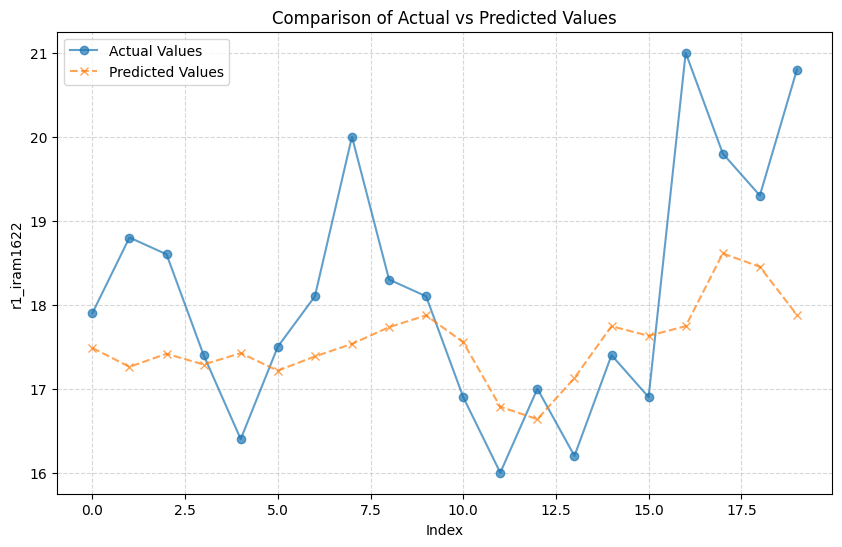

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Values', marker='o', linestyle='-', alpha=0.7)
plt.plot(test_predictions, label='Predicted Values', marker='x', linestyle='--', alpha=0.7)
plt.title("Comparison of Actual vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("r1_iram1622")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()